In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np

In [0]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_data_X, Y_data, test_size=0.33, random_state=42)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating initial dataframe

y_train_df = pd.DataFrame(y_train, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])
y_test_df = pd.DataFrame(y_test, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_test_df['New'] = labelencoder.fit_transform(y_test_df['Label'])

In [0]:
from keras import backend as K
img_rows, img_cols = X_train[0].shape


# transform data set
if K.common.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Using TensorFlow backend.


**Parseval Network**

**Constrait**

In [0]:
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


def initial_conv(input):

    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.common.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, W_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":
    from keras.utils import plot_model
    from keras.layers import Input
    from keras.models import Model

    init = (68, 100,1)

    wrn_28_10 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.0)

    wrn_28_10.summary()

   # plot_model(wrn_28_10, "WRN-16-2.png", show_shapes=True, show_layer_names=True)


Parseval Residual Network-16-2 created.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 100, 16)  144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 68, 100, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 68, 100, 16)  0           batch_normalization_1[0][0]      
____________________________________________________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils

In [0]:
EPOCHS = 60
BS = 128
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

In [0]:
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.2
  epochs_drop = 60
  lrate = 0.1
  if math.floor((1+epoch)/epochs_drop) !=0:
    lrate = initial_lrate*math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate
 
sgd = SGD(lr=0.1, momentum=0.9)

In [0]:
wrn_28_10.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [0]:
from keras.utils import to_categorical

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
hist = wrn_28_10.fit(X_train, to_categorical(y_train_df['New']), validation_split=0.33, epochs=EPOCHS, batch_size=BS, verbose=2, callbacks=callbacks_list)

Train on 2568 samples, validate on 1265 samples
Epoch 1/60
 - 24s - loss: 1.8528 - acc: 0.3232 - val_loss: 1.9409 - val_acc: 0.2680
Epoch 2/60
 - 18s - loss: 1.7911 - acc: 0.3676 - val_loss: 1.7731 - val_acc: 0.3755
Epoch 3/60
 - 18s - loss: 1.7330 - acc: 0.3956 - val_loss: 1.7786 - val_acc: 0.3731
Epoch 4/60
 - 18s - loss: 1.7176 - acc: 0.4062 - val_loss: 1.6921 - val_acc: 0.4269
Epoch 5/60
 - 18s - loss: 1.6708 - acc: 0.4143 - val_loss: 1.6619 - val_acc: 0.4308
Epoch 6/60
 - 18s - loss: 1.6240 - acc: 0.4517 - val_loss: 1.6473 - val_acc: 0.4213
Epoch 7/60
 - 18s - loss: 1.5854 - acc: 0.4564 - val_loss: 1.6719 - val_acc: 0.4522
Epoch 8/60
 - 18s - loss: 1.5863 - acc: 0.4494 - val_loss: 1.6373 - val_acc: 0.4269
Epoch 9/60
 - 18s - loss: 1.5603 - acc: 0.4607 - val_loss: 1.5830 - val_acc: 0.4601
Epoch 10/60
 - 18s - loss: 1.5128 - acc: 0.4817 - val_loss: 1.5425 - val_acc: 0.4522
Epoch 11/60
 - 18s - loss: 1.4831 - acc: 0.4938 - val_loss: 1.5037 - val_acc: 0.4767
Epoch 12/60
 - 18s - loss:

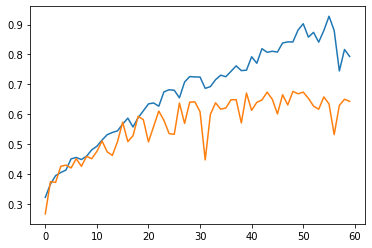

In [0]:
from matplotlib import  pyplot


pyplot.plot(hist.history["acc"], label='train')
pyplot.plot(hist.history['val_acc'], label='test')


In [0]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 


Tensorflow Version: 2.0.0-beta1
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
GPU Available:  False


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [0]:
from cleverhans.future.tf2.attacks import fast_gradient_method




In [0]:
x = tf.placeholder(tf.float32, shape=(None, 1, 28, 28))
y = tf.placeholder(tf.float32, shape=(None, FLAGS.nb_classes))

# Define TF model graph
model = model_mnist()
predictions = model(x)

RuntimeError: ignored